In [1]:
import numpy as np
import time
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
from matplotlib import pyplot as plt
%matplotlib inline
import VBHelperFunctions
import mouseQPCRModelSelection

In [2]:
pt,Yall = mouseQPCRModelSelection.LoadMouseQPCRData(subsetSelection=0)

Loaded GPLVM data/guo_ssData.p with nrowsXncols = (437, 2).
LoadMouseQPCRData output


In [3]:
import pods
g = 'Id2'
print  'Load gene expression'
data = pods.datasets.singlecell()
genes = data['Y']  
Y = genes[g].values[:,None]    
t0=time.time()  
N = Y.shape[0]
labels = data['labels']
stageCell = np.zeros(N)
stageN = np.zeros(N)
for i,l in enumerate(labels):
    stageCell[i] = int(l[:2])
    stageN[i] = np.log2(stageCell[i]) + 1
    
pt = stageN

Load gene expression


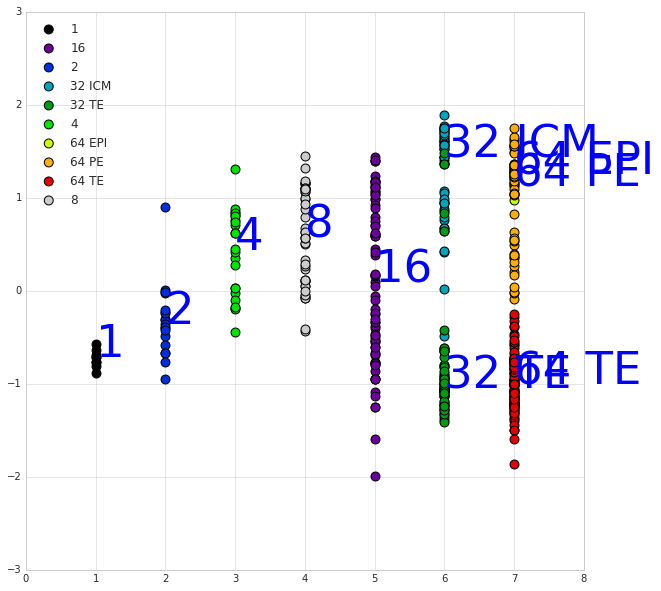

In [4]:
def plotGene(t,g,labels):
    import matplotlib.cm as cm
    labelLegend = np.unique(labels)
    with plt.style.context('seaborn-whitegrid'):
        colors = cm.spectral(np.linspace(0, 1, len(labelLegend)))
        plt.figure(figsize=(10, 10))
        for lab,c in zip(labelLegend,colors):
            y1 = t[labels == lab]
            y2 = g[labels == lab]
            plt.scatter(y1,y2,label=lab, c=c,s=80)
            plt.text(np.median(y1),np.median(y2),lab, fontsize=45, color='blue')
        plt.legend(loc='upper left')
plotGene(pt, Y, labels)

('\riteration 1 bound=-19410.1746043 grad=7665.5969511, beta=0',)
('\riteration 2 bound=-18553.2485133 grad=23259.5960491, beta=1.82164039737',)
('\riteration 3 bound=-11192.069816 grad=153751.326637, beta=2.57856335249',)
('\riteration 4 bound=-4372.41478154 grad=652534.103906, beta=1.50473112095',)
('\riteration 5 bound=-3741.04030245 grad=95421.7490004, beta=0.0',)
('\riteration 6 bound=-3464.31385125 grad=38706.2354019, beta=0.0',)
('\riteration 7 bound=-3311.15858739 grad=20691.5608269, beta=0.0',)
('\riteration 8 bound=-3208.21370719 grad=14127.5861396, beta=0.0',)
('\riteration 9 bound=-3133.99505318 grad=10260.3373873, beta=0.0',)
('\riteration 10 bound=-3076.90359751 grad=8880.58833658, beta=0.0',)
('\riteration 11 bound=-3032.4302602 grad=7101.7423351, beta=0.0',)
('\riteration 12 bound=-2995.36757138 grad=6758.95919831, beta=0.0',)
('\riteration 13 bound=-2964.77373641 grad=5652.85848496, beta=0.0',)
('\riteration 14 bound=-2936.6163761 grad=5698.96833917, beta=0.0',)
('\rit

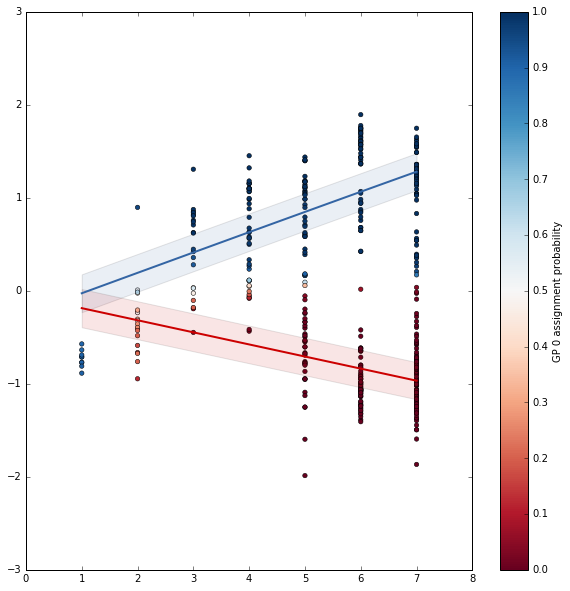

In [5]:
from GPclust import OMGP
m = OMGP(pt[:,None], Y, K=2, variance=0.01, prior_Z='DP') # use a truncated DP with K=2
m.rbf.lengthscale = 65
m.rbf_1.lengthscale = 65
m.optimize(step_length=0.01, maxiter=20)
fig=plt.figure(figsize=(10,10))
m.plot()

('\riteration 1 bound=-2797.27690221 grad=3988.49543797, beta=0',)
('\riteration 2 bound=-2783.04024112 grad=4345.03184679, beta=0.0',)
('\riteration 3 bound=-2771.16514115 grad=3640.32392966, beta=0.0',)
('\riteration 4 bound=-2759.00079859 grad=4132.2877447, beta=0.0',)
('\riteration 5 bound=-2748.02786774 grad=3586.62632501, beta=0.0',)
('\riteration 6 bound=-2735.49254994 grad=4083.61774358, beta=0.0',)
('\riteration 7 bound=-2723.46546421 grad=3584.12302354, beta=0.0',)
('\riteration 8 bound=-2709.24229578 grad=4240.37766422, beta=0.0',)
('\riteration 9 bound=-2694.28500714 grad=3921.64771316, beta=0.0',)
('\riteration 10 bound=-2675.89469063 grad=4583.39239736, beta=0.0',)
('\riteration 11 bound=-2656.43751494 grad=4286.81986367, beta=0.0',)
('\riteration 12 bound=-2633.76933982 grad=5054.1683947, beta=0.0',)
('\riteration 13 bound=-2610.39993806 grad=4815.00100932, beta=0.0',)
('\riteration 14 bound=-2585.13718893 grad=5361.16173844, beta=0.0',)
('\riteration 15 bound=-2562.0566

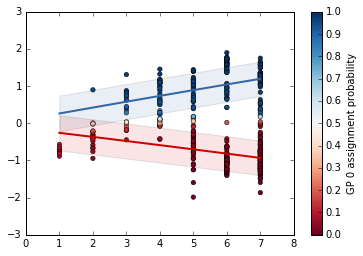

In [6]:
m.optimize(step_length=0.01, maxiter=100)
m.plot()

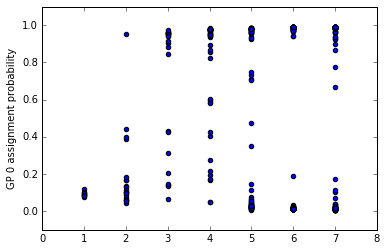

In [7]:
m.plot_probs()

In [8]:
m

OMGP.,value,constraints,priors
variance,0.0540319404468,+ve,
rbf.variance,27.1768563586,+ve,
rbf.lengthscale,63.3313367451,+ve,
rbf_1.variance,25.2085878734,+ve,
rbf_1.lengthscale,63.5180517666,+ve,


# VB Branching code

In [9]:
import BranchingTree as bt
import branch_kernParamGPflow as bk
def InitModels(pt, XExpanded, Y):
    # code that's a bit crappy - we dont need this
    tree = bt.BinaryBranchingTree(0,90,fDebug=False) # set to true to print debug messages
    tree.add(None,1,10) # single branching point
    (fm, _) = tree.GetFunctionBranchTensor()
    #KbranchVB = bk.BranchKernelParam(GPflow.kernels.RBF(1), fm, BvInitial=np.ones((1,1))) + GPflow.kernels.White(1) 
    KbranchVB = bk.BranchKernelParam(GPflow.kernels.RBF(1), fm, BvInitial=np.ones((1,1))) + GPflow.kernels.White(1) + GPflow.kernels.Linear(1) + GPflow.kernels.Constant(1) # other copy of kernel
    KbranchVB.branchkernelparam.Bv.fixed = True
    mV = assigngp_dense.AssignGP(pt, XExpanded, Y, KbranchVB)
    mV.kern.white.variance = 1e-6
    mV.kern.white.variance.fixed = True
    mV._compile() # creates objective function
    return mV

In [10]:
phiInitial, phiInitial_invSoftmax, XExpanded = VBHelperFunctions.InitialisePhiFromOMGP(None, phiOMGP=m.phi, b=0, Y=Y,pt=pt)   
mV = InitModels(pt,XExpanded,Y) # also do gene by gene

compiling tensorflow function...
done


In [11]:
mV

Name,values,prior,constriant
model.likelihood.variance,[ 1.],None,+ve
model.kern.linear.variance,[ 1.],None,+ve
model.kern.constant.variance,[ 1.],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.kern.branchkernelparam.Bv,[[ 1.]],None,[FIXED]
model.kern.branchkernelparam.kern.lengthscales,[ 1.],None,+ve
model.kern.branchkernelparam.kern.variance,[ 1.],None,+ve
model.logPhi,"[[ -2.92829526e+00 -3.10224741e-01 5.32952874e-01 ..., 5.77130869e-02 -9.40559103e-01 2.16295224e+00] [ -6.25285954e-01 2.27844636e+00 5.28733079e-01 ..., 3.34013101e-01 -6.39573101e-01 -1.37894746e+00] [ 1.11147997e+00 -2.12825372e+00 2.21662605e-01 ..., -1.21706888e+00 -2.84951987e-01 8.02222268e-01] ..., [ 8.69055583e-02 -9.96534924e-01 1.70743505e-03 ..., -7.83228918e-01 -6.32121582e-01 4.15701268e-01] [ -4.50536649e-01 -3.86697414e-01 -1.21817734e+00 ..., 2.13815258e-01 1.74362071e+00 2.74957134e-01] [ -1.07222889e+00 -2.81461701e+00 1.14458149e+00 ..., 1.37540156e+00 3.18949510e-02 -1.75398607e-01]]",None,(none)


In [12]:
m

OMGP.,value,constraints,priors
variance,0.0540319404468,+ve,
rbf.variance,27.1768563586,+ve,
rbf.lengthscale,63.3313367451,+ve,
rbf_1.variance,25.2085878734,+ve,
rbf_1.lengthscale,63.5180517666,+ve,


In [13]:
# Initialise all model parameters using the OMGP model
# Note that the OMGP model has different kernel hyperparameters for each latent function whereas the branching model
# has one common set.
mV.logPhi = phiInitial_invSoftmax # initialise allocations from OMGP
mV.likelihood.variance = m.variance.values[0]
# set lengthscale to maximum
mV.kern.branchkernelparam.kern.lengthscales = np.max(np.array([m.rbf.lengthscale.values, m.rbf_1.lengthscale.values]))
# set process variance to average
mV.kern.branchkernelparam.kern.variance = np.mean(np.array([m.rbf.variance.values, m.rbf_1.variance.values]))
mV

Name,values,prior,constriant
model.likelihood.variance,[ 0.05403194],None,+ve
model.kern.linear.variance,[ 1.],None,+ve
model.kern.constant.variance,[ 1.],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.kern.branchkernelparam.Bv,[[ 1.]],None,[FIXED]
model.kern.branchkernelparam.kern.lengthscales,[ 63.51805177],None,+ve
model.kern.branchkernelparam.kern.variance,[ 26.19272212],None,+ve
model.logPhi,"[[ -2.76310211e+01 -2.45772542e+00 -8.95194294e-02 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] ..., [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -2.76310211e+01 -4.15069013e+00 -1.58789466e-02]]",None,(none)


In [14]:
def FlattenPhi(mV):
    # return flattened and rounded Phi i.e. N X 3
    phiFlattened = np.zeros((mV.Y.shape[0],3)) # only single branching point
    Phi = np.round(np.exp(mV.logPhi._array),decimals=4)
    f=2 # which function to plot phi against - can be 1,2 or 3
    iterC=0
    for i,p in enumerate(mV.t):
        phiFlattened[i,:] = Phi[i,iterC:iterC+3] 
        iterC+=3
    return phiFlattened
Phi=FlattenPhi(mV)

In [15]:
def plotVBCode(mV,figsizeIn=(20,10),lw=3.,fs=10):
    from matplotlib import cm
    D = mV.Y.shape[0]
    fig=plt.figure(figsize=figsizeIn)
    B=mV.kern.branchkernelparam.Bv._array.flatten()
    assert B.size == 1, 'Code limited to one branch point, got ' + str(B.shape)
    pt = mV.t
    l = np.min(pt)
    u = np.max(pt)
    d = 0 # constraint code to be 1D for now
    for f in range(1, 4):
        if(f == 1):
            ttest = np.linspace(l, B, 100)[:, None]  # root
        else:
            ttest = np.linspace(B, u, 100)[:, None]
        Xtest = np.hstack((ttest, ttest*0+f))
        mu, var = mV.predict_f(Xtest)
        assert np.all(np.isfinite(mu)), 'All elements should be finite but are ' + str(mu)
        assert np.all(np.isfinite(var)), 'All elements should be finite but are ' + str(var)
        mean, = plt.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        plt.plot(ttest.flatten(), mu[:, d] + 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
        plt.plot(ttest, mu[:, d] - 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)

    v = plt.axis()
    plt.plot([B, B], v[-2:], '-m',linewidth=lw)
    
    # could also plot phi
    Phi=FlattenPhi(mV)
    gp_num = 1 # can be 0,1,2 
    plt.scatter(pt, mV.Y[:,d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
    plt.colorbar(label='GP {} assignment probability'.format(gp_num))


# Bayesian optimisation
1. Use GPyOpt to learn branching point and kernel hyperparameters.
1. set fixed=False for all parameters except for Phi.fixed=True
1. It's still beneficial to use *VB code* rather than *Jings model* since we integrate out (approximately using VB bound) uncertainty in allocation (Phi).
1. Store all intermediate values visited by GPyOpt?
1. Use Matern 3/2 or 5/2 for both OMGP and our model. Actually different kernels for OMGP and our can make sense as outputs different (potentially)?
1. Effect of Phi on inference of branching point?
1. add assert in VB code that before branching point, allocations probs==1 for 1st function.


In [16]:
import GPyOpt

In [17]:
# Objective function
class objectiveBAndK:
    def __init__(self, Binit):
        mV.kern.branchkernelparam.Bv.fixed = False # we wont optimize so this is fine
        mV.logPhi.fixed = False # allocations not fixed for GPyOpt because we update them for each branch point

        mV.likelihood.variance.fixed = False # all kernel parameters optimised
        mV.kern.branchkernelparam.kern.lengthscales.fixed = False
        mV.kern.branchkernelparam.kern.variance.fixed = False

        # initial branch point
        mV.kern.branchkernelparam.Bv = Binit
        VBHelperFunctions.InitialisePhiFromOMGP(mV, phiOMGP=m.phi, b=Binit, Y=Y, pt=pt)  
        # Initialise all model parameters using the OMGP model 
        mV.likelihood.variance = m.variance.values[0]
        mV.kern.branchkernelparam.kern.lengthscales = np.max(np.array([m.rbf.lengthscale.values, m.rbf_1.lengthscale.values]))
        mV.kern.branchkernelparam.kern.variance = np.mean(np.array([m.rbf.variance.values, m.rbf_1.variance.values]))
        mV._compile()

    def f(self, theta):
        # theta is nxp array, return nx1
        n=theta.shape[0]
        VBboundarray = np.ones((n,1))
        for i in range(n):
            mV.kern.branchkernelparam.Bv = theta[i,0]
            VBHelperFunctions.InitialisePhiFromOMGP(mV, phiOMGP=m.phi, b=theta[i,0], Y=Y, pt=pt)  
            mV.likelihood.variance = theta[i,1]
            mV.kern.branchkernelparam.kern.lengthscales = theta[i,2]
            mV.kern.branchkernelparam.kern.variance = theta[i,3]
            mV.kern.linear.variance = theta[i,4]
            mV.kern.constant.variance = theta[i,5]
            
            VBboundarray[i] = -mV.compute_log_likelihood() # we wish to minimize!
            print 'objectiveB B=%.0f likvar=%.0f len=%.0f var=%.0f linvar=%.0f constvar=%.0f VB=%.0f'\
            %(theta[i,0], theta[i,1], theta[i,2], theta[i,3], theta[i,4],theta[i,5],VBboundarray[i] )
        return VBboundarray

In [24]:
# try optimisation
l = pt.min() + 1
u = pt.max() - 1
print l,u
# We need constraints on there parameters
# B = [l,u] 
# lik.variance > 0
# kern.lengthscale, variance > 0

# --- Optimize both B and K
myobj = objectiveBAndK(np.ones((1,1))*(l+u)/2) # pass in initial point - start at mid-point
eps = 1e-5
#bounds = [(l,u),(eps,3*Y.var()), (eps,pt.max()), (eps,3*Y.var())]  # B, lik var, len, var

bounds = [(l,u),(eps,3*Y.var()), (eps+2,pt.max()), (eps,3*Y.var()), [0.1,5], [4,10]]  # B, lik var, len, var, lin var, c var

BOobj = GPyOpt.methods.BayesianOptimization(f=myobj.f,  # function to optimize       
                                            bounds=bounds)              # normalized y                       
t0=time.time()
max_iter = 20 
import multiprocessing
n_cores = multiprocessing.cpu_count()

BOobj.run_optimization(max_iter,                             # Number of iterations
                       acqu_optimize_method = 'fast_random',        # method to optimize the acq. function
                       acqu_optimize_restarts = 30,
                       batch_method='lp',
                       n_inbatch = n_cores,                        # size of the collected batches (= number of cores)
                       eps = 1e-6)                                # secondary stop criteria (apart from the number of iterations) 

print 'GPyOpt took %g secs ' %(time.time()-t0)

2.0 6.0
compiling tensorflow function...
done
objectiveB B=5 likvar=3 len=5 var=1 linvar=0 constvar=8 VB=1085
objectiveB B=4 likvar=2 len=7 var=1 linvar=4 constvar=7 VB=1020
objectiveB B=5 likvar=0 len=3 var=3 linvar=5 constvar=4 VB=877
objectiveB B=5 likvar=2 len=7 var=0 linvar=2 constvar=4 VB=1071
objectiveB B=3 likvar=1 len=4 var=3 linvar=3 constvar=9 VB=887
objectiveB B=5 likvar=3 len=4 var=1 linvar=2 constvar=8 VB=1059
objectiveB B=5 likvar=3 len=3 var=1 linvar=0 constvar=7 VB=1046
objectiveB B=5 likvar=1 len=4 var=1 linvar=2 constvar=10 VB=890
objectiveB B=5 likvar=0 len=7 var=1 linvar=3 constvar=7 VB=2163
objectiveB B=6 likvar=0 len=4 var=3 linvar=0 constvar=7 VB=903
objectiveB B=6 likvar=1 len=3 var=0 linvar=1 constvar=7 VB=973
objectiveB B=5 likvar=1 len=4 var=2 linvar=2 constvar=7 VB=896
objectiveB B=2 likvar=1 len=2 var=1 linvar=5 constvar=8 VB=900
objectiveB B=2 likvar=2 len=6 var=1 linvar=4 constvar=6 VB=1010
objectiveB B=2 likvar=3 len=6 var=0 linvar=3 constvar=10 VB=1123

In [25]:
print 'Solution found by BO'
print BOobj.x_opt
print BOobj.fx_opt

# Can explicitly check computation using myobj.f(np.ones((1,1))*16.834)
# should add assert that Phi before branching point is 1 everywhere!

Solution found by BO
[ 3.09583718  0.35146725  2.69714807  1.58985697  4.19823409  9.2432377 ]
[ 848.8128611]


In [29]:
def plotVBCode(mV,figsizeIn=(20,10),lw=3.,fs=10,labels=None, fPlotPhi=True, fPlotVar=True):
    import matplotlib.cm as cm
    from matplotlib import cm
    D = mV.Y.shape[0]
    fig=plt.figure(figsize=figsizeIn)
    B=mV.kern.branchkernelparam.Bv._array.flatten()
    assert B.size == 1, 'Code limited to one branch point, got ' + str(B.shape)
    pt = mV.t
    l = np.min(pt)
    u = np.max(pt)
    d = 0 # constraint code to be 1D for now
    for f in range(1, 4):
        if(f == 1):
            ttest = np.linspace(l, B, 100)[:, None]  # root
        else:
            ttest = np.linspace(B, u, 100)[:, None]
        Xtest = np.hstack((ttest, ttest*0+f))
        mu, var = mV.predict_f(Xtest)
        assert np.all(np.isfinite(mu)), 'All elements should be finite but are ' + str(mu)
        assert np.all(np.isfinite(var)), 'All elements should be finite but are ' + str(var)
        mean, = plt.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        if(fPlotVar):
            plt.plot(ttest.flatten(), mu[:, d] + 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
            plt.plot(ttest, mu[:, d] - 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)

    v = plt.axis()
    plt.plot([B, B], v[-2:], '-m',linewidth=lw)
    
    # Plot Phi or labels
    if(fPlotPhi):
        Phi=FlattenPhi(mV)
        gp_num = 1 # can be 0,1,2 
        plt.scatter(pt, mV.Y[:,d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
        plt.colorbar(label='GP {} assignment probability'.format(gp_num))
    elif(labels is not None):
        # plot labels
        labelLegend = np.unique(labels)
        with plt.style.context('seaborn-whitegrid'):
            colors = cm.spectral(np.linspace(0, 1, len(labelLegend)))
            for lab,c in zip(labelLegend,colors):
                y1 = pt[labels == lab]
                y2 = Y[labels == lab]
                plt.scatter(y1,y2,label=lab, c=c,s=80)
                plt.text(np.median(y1),np.median(y2),lab, fontsize=45, color='blue')
            plt.legend(loc='upper left')

Bound got 847.96 should be 848.81


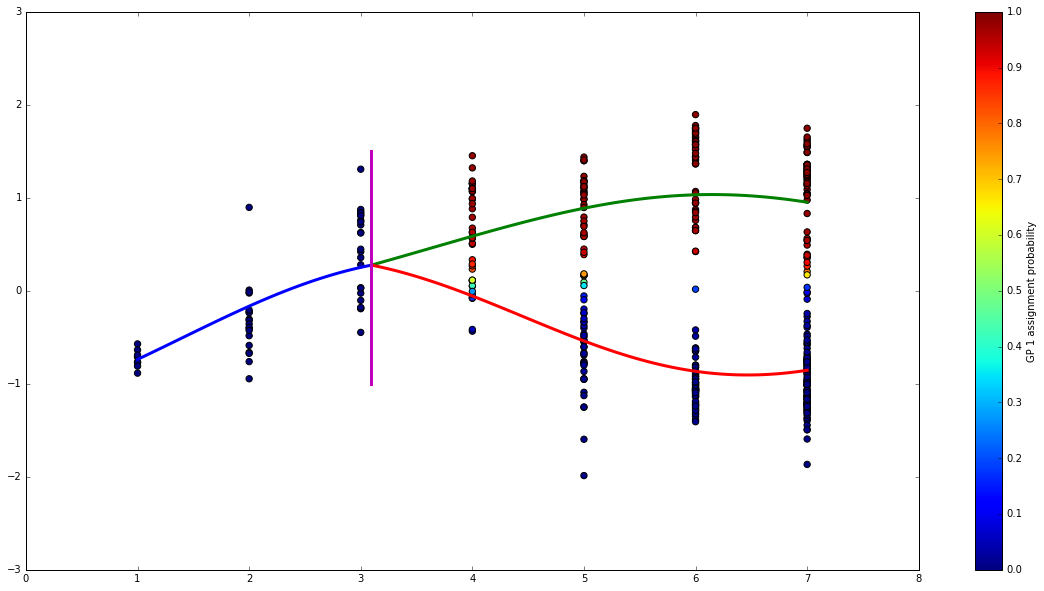

In [30]:
# plot best solution
mV.kern.branchkernelparam.Bv = BOobj.x_opt[0]
VBHelperFunctions.InitialisePhiFromOMGP(mV, phiOMGP=m.phi, b=BOobj.x_opt[0],Y=Y,pt=pt)   
mV.likelihood.variance = BOobj.x_opt[1]
mV.kern.branchkernelparam.kern.lengthscales = BOobj.x_opt[2]
mV.kern.branchkernelparam.kern.variance = BOobj.x_opt[3]
print 'Bound got %.2f should be %.2f'%(-mV.compute_log_likelihood(), BOobj.fx_opt)
plotVBCode(mV,fPlotVar=False)

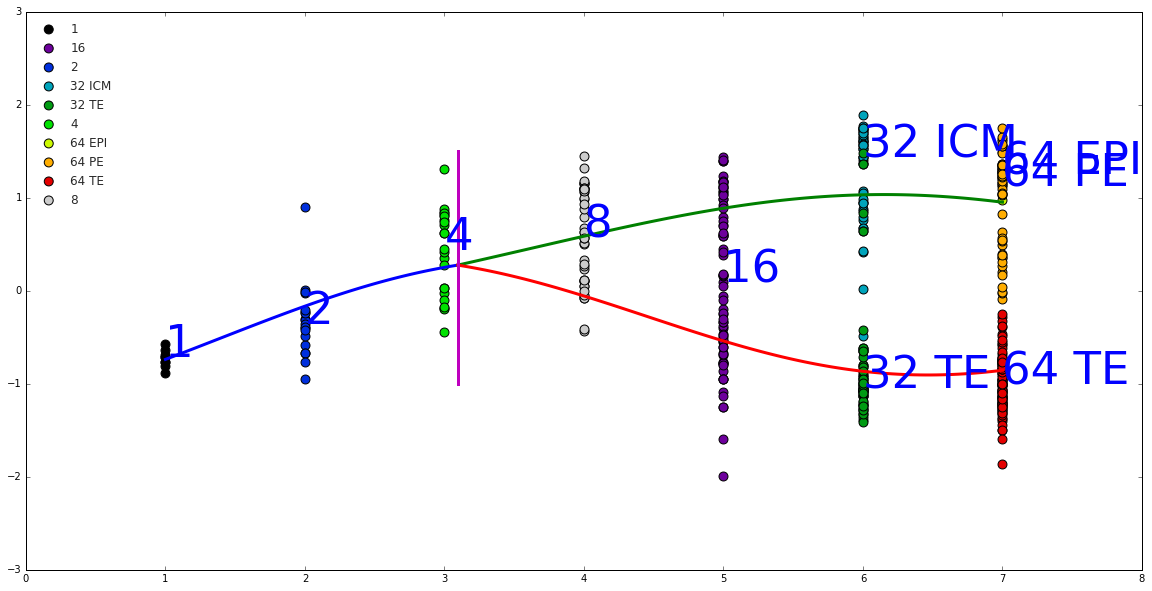

In [31]:
plotVBCode(mV,labels=labels,fPlotPhi=False,fPlotVar=False)

In [28]:
mV

Name,values,prior,constriant
model.likelihood.variance,[ 0.35146725],None,+ve
model.kern.linear.variance,[ 0.73194003],None,+ve
model.kern.constant.variance,[ 9.10121686],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.kern.branchkernelparam.Bv,[[ 3.09583718]],None,(none)
model.kern.branchkernelparam.kern.lengthscales,[ 2.69714807],None,+ve
model.kern.branchkernelparam.kern.variance,[ 1.58985697],None,+ve
model.logPhi,"[[ -1.99995576e-12 -2.76310211e+01 -2.76310211e+01 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] ..., [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -9.00000000e+00 -9.00000000e+00 -9.00000000e+00] [ -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 ..., -2.76310211e+01 -4.15069013e+00 -1.58789466e-02]]",None,(none)
